In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB6

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 528
BATCH_SIZE = 64

2024-11-05 09:40:23.477346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 09:40:23.497193: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 09:40:23.647098: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 09:40:23.781471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 09:40:23.895161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
dataset_name = "beans"
(ds_train, ds_test, ds_val), ds_info = tfds.load(
    dataset_name, split=["train", "test", "validation"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [4]:
size = (IMG_SIZE, IMG_SIZE)
ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))


2024-10-11 11:19:53.776837: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-11 11:19:53.798652: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


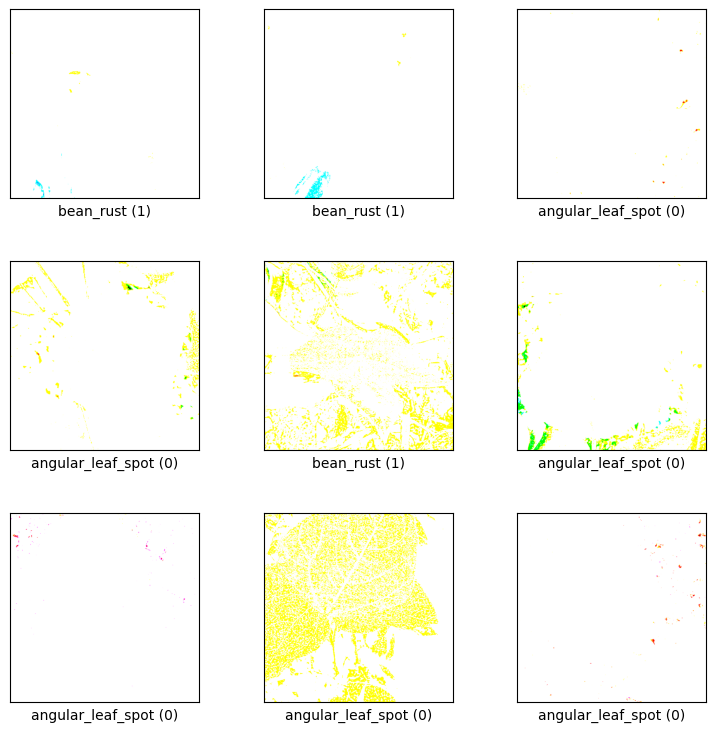

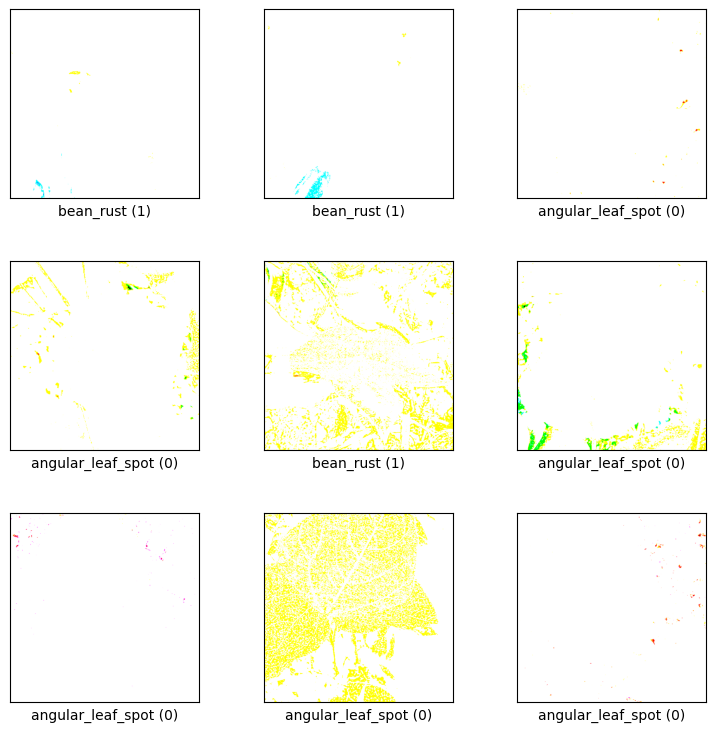

In [11]:
tfds.visualization.show_examples(ds=ds_train,  ds_info = ds_info )

In [13]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label

beansImages = {}
label_info = ds_info.features["label"]
for label_name in label_info.names:
    beansImages[label_name] = []
for i, (image, label) in enumerate(ds_train):
    beansImages[format_label(label)].append(image)
for label_name in label_info.names:
    print (f"Total of {label_name} leaves: {len(beansImages[label_name])}")

Total of angular_leaf_spot leaves: 345
Total of bean_rust leaves: 348
Total of healthy leaves: 341


2024-11-05 10:18:46.200345: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


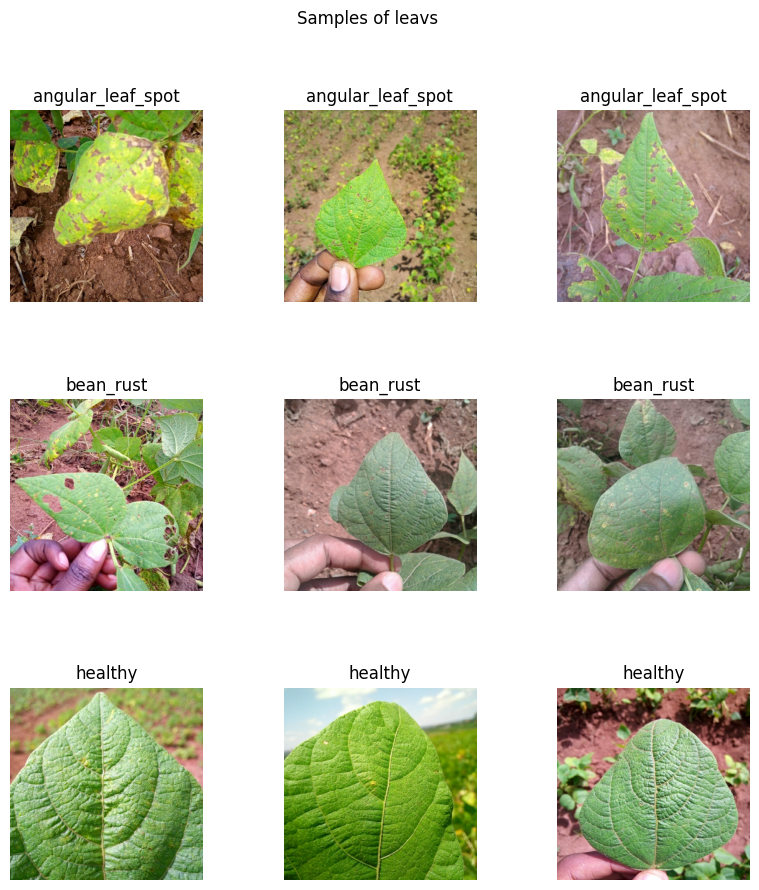

In [28]:
import random

def plot_sample_images():
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Samples of leavs')
    for i, label in enumerate(beansImages.keys()):
        for j in range(3):
            randeom_index = random.randint(0, len(beansImages[label]) -1)	
            img = beansImages[label][randeom_index].numpy().astype("uint8")
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(label)
    plt.show()
plot_sample_images()

In [29]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [30]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size=BATCH_SIZE, drop_remainder=True)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [31]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB6(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [29]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_val)


165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/25


2024-09-20 10:43:25.175409: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 426s 26s/step - accuracy: 0.6756 - loss: 1.4023 - val_accuracy: 0.4062 - val_loss: 1.4661
Epoch 2/25


2024-09-20 10:50:19.569065: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 415s 26s/step - accuracy: 0.8619 - loss: 0.7647 - val_accuracy: 0.6172 - val_loss: 0.8414
Epoch 3/25


2024-09-20 10:57:14.096053: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 415s 26s/step - accuracy: 0.8939 - loss: 0.4686 - val_accuracy: 0.5938 - val_loss: 1.8970
Epoch 4/25


2024-09-20 11:04:08.828052: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 420s 26s/step - accuracy: 0.9094 - loss: 0.3370 - val_accuracy: 0.5859 - val_loss: 0.9858
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 410s 26s/step - accuracy: 0.9093 - loss: 0.4838 - val_accuracy: 0.6953 - val_loss: 0.6838
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 429s 27s/step - accuracy: 0.9089 - loss: 0.3734 - val_accuracy: 0.6484 - val_loss: 1.1148
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 419s 26s/step - accuracy: 0.8787 - loss: 0.5121 - val_accuracy: 0.9141 - val_loss: 0.2806
Epoch 8/25


2024-09-20 11:32:07.779158: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 416s 26s/step - accuracy: 0.9039 - loss: 0.4192 - val_accuracy: 0.7969 - val_loss: 0.5265
Epoch 9/25


2024-09-20 11:39:04.152048: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 426s 27s/step - accuracy: 0.9094 - loss: 0.4462 - val_accuracy: 0.8984 - val_loss: 0.2927
Epoch 10/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 415s 26s/step - accuracy: 0.9082 - loss: 0.4097 - val_accuracy: 0.9219 - val_loss: 0.2645
Epoch 11/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 413s 26s/step - accuracy: 0.9270 - loss: 0.2894 - val_accuracy: 0.7891 - val_loss: 0.5337
Epoch 12/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 413s 26s/step - accuracy: 0.9176 - loss: 0.4561 - val_accuracy: 0.9531 - val_loss: 0.1682
Epoch 13/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 409s 26s/step - accuracy: 0.9105 - loss: 0.5407 - val_accuracy: 0.9297 - val_loss: 0.2083
Epoch 14/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 408s 26s/step - accuracy: 0.8996 - loss: 0.6098 - val_accuracy: 0.7969 - val_loss: 0.7066
Epoch 15/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 416s 26s/step - accuracy: 0.9193 - loss: 0.4763 - val_accuracy: 0.9219 - val_loss: 0.3539
Epoch 16/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 411s 26s/step - accuracy: 0.9275 - loss: 0.4517 - val_accuracy: 0.9453

NameError: name 'plot_hist' is not defined

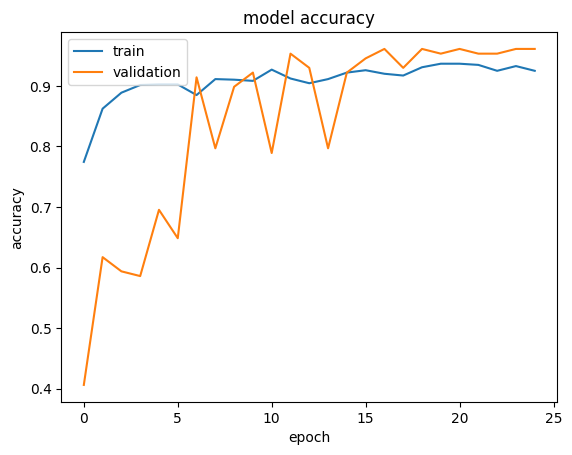

In [31]:
plot_hist(hist)

In [59]:
# save the model 
model.save('my_model.keras')


In [5]:
model = tf.keras.models.load_model('my_model.keras')


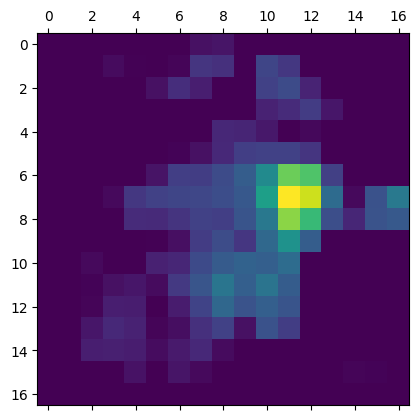

In [25]:
import cv2
import random

from tensorflow.keras.models import Model


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the model's output for the specified layer
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Get the last convolutional layer's output and model predictions
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get the gradients of the class channel with respect to the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute the average of the gradients for each feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps by the gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU to remove negative values, as we only care about positive influences
    heatmap = np.maximum(heatmap, 0)

    # Normalize to range [0, 1] for visualization
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

last_conv_layer_name = "top_conv" 

random_image = random.choice(beansImages["angular_leaf_spot"])

random_image_dim = np.expand_dims(random_image, axis=0)  # Add batch dimension


# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(random_image_dim, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

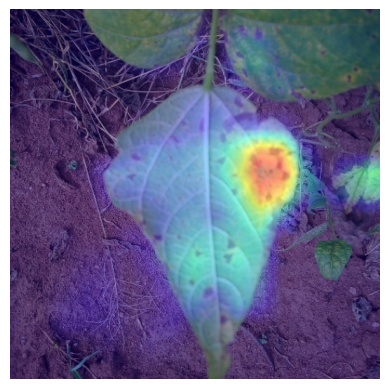

In [26]:
# Function to overlay the heatmap on the original image
def overlay_heatmap(heatmap, img, alpha=0.4):
    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to a color map (for visualization)
    heatmap = np.uint8(255 * heatmap)  # Scale to 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Ensure both images are uint8
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    if heatmap.dtype != np.uint8:
        heatmap = heatmap.astype(np.uint8)

    # Overlay the heatmap on the original image
    overlayed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img

# Generate the overlayed image
    # Convert tensor to numpy array and prepare for overlay
# Ensure the heatmap is in the correct format (float and range [0, 1])
heatmap = np.maximum(heatmap, 0)  # Ensure no negative values
heatmap /= np.max(heatmap)  # Normalize to [0, 1]
random_image_np = random_image.numpy()  # Convert to NumPy array
original_image = cv2.cvtColor(random_image_np, cv2.COLOR_RGB2BGR) 
overlayed_img = overlay_heatmap(heatmap, original_image)
plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 49s 21s/step


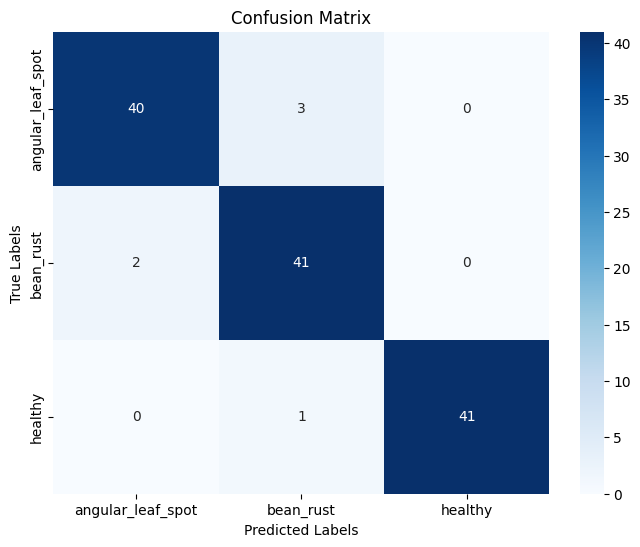

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Convert true labels to single-label format
true_labels = np.concatenate([np.argmax(y, axis=1) for x, y in ds_test], axis=0)

# Step 2: Get predicted labels (already handled with np.argmax)
predictions = model.predict(ds_test, batch_size=BATCH_SIZE)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_names = ds_info.features['label'].names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()